In [2]:
%load_ext autoreload
%autoreload 2

# Import models from MIRA

In [3]:
import json
import pickle
import networkx as nx

# Pre-compiled MIRA examples
from mira.examples.sir import sir_parameterized

%aimport pyciemss.utils

/Users/zuck016/.pyenv/versions/3.10.9/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Convert model to ODE 

In [4]:

import torch
import torchdiffeq
import matplotlib.pyplot as plt

petri_G = pyciemss.utils.load_mira(sir_parameterized)
petri_G = pyciemss.utils.add_state_indicies(petri_G)
sir_ode_func = pyciemss.utils.petri_to_ode(petri_G)
petri_G.nodes(data=True)

NodeDataView({'susceptible_population': {'sname': 'susceptible_population', 'mira_ids': "[('identity', 'ido:0000514')]", 'mira_context': '[]', 'mira_initial_value': 1.0, 'type': 'state', 'state_index': 0}, 'infected_population': {'sname': 'infected_population', 'mira_ids': "[('identity', 'ido:0000511')]", 'mira_context': '[]', 'mira_initial_value': 2.0, 'type': 'state', 'state_index': 1}, 'immune_population': {'sname': 'immune_population', 'mira_ids': "[('identity', 'ido:0000592')]", 'mira_context': '[]', 'mira_initial_value': 3.0, 'type': 'state', 'state_index': 2}, 't1': {'tname': 't1', 'template_type': 'ControlledConversion', 'parameter_name': 'beta', 'parameter_value': 0.1, 'type': 'transition'}, 't2': {'tname': 't2', 'template_type': 'NaturalConversion', 'parameter_name': 'gamma', 'parameter_value': 0.2, 'type': 'transition'}})

In [5]:
for edge in petri_G.edges(data=False):
    print(edge)

('susceptible_population', 't1')
('infected_population', 't1')
('infected_population', 't2')
('t1', 'infected_population')
('t1', 'infected_population')
('t2', 'immune_population')


In [6]:

pyciemss.utils.get_mira_initial_values(petri_G)

{'susceptible_population': tensor(1.),
 'infected_population': tensor(2.),
 'immune_population': tensor(3.)}

In [7]:
pyciemss.utils.get_mira_parameter_values(petri_G)

{'beta': tensor(0.1000), 'gamma': tensor(0.2000)}

## Get initial values from MIRA

In [4]:
 
state0 = pyciemss.utils.order_state(petri_G, **pyciemss.utils.get_mira_initial_values(petri_G))
print(state0)

(tensor(1.), tensor(2.), tensor(3.))


## Plot arbitrary sized models

(tensor(-0.2000), tensor(-0.2000), tensor(0.4000))


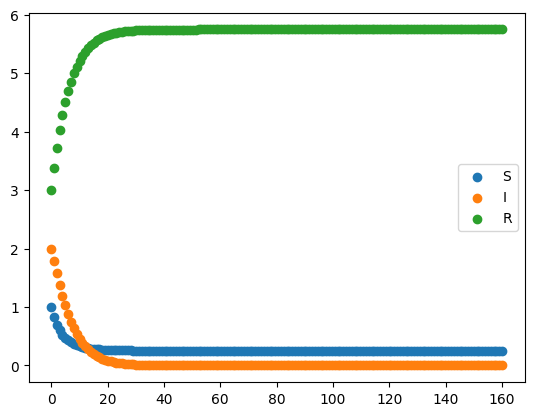

In [10]:

tspan = torch.linspace(0, 160., 160)
print(sir_ode_func(tspan[0], state0))
jit_sir_ode_func = torch.jit.trace(sir_ode_func, (tspan[0], state0))
soln = torchdiffeq.odeint(jit_sir_ode_func, state0, tspan)
plt.scatter(tspan, soln[0], label="S")
plt.scatter(tspan, soln[1], label="I")
plt.scatter(tspan, soln[2], label="R")
plt.legend()

{'state': ['susceptible_population', 'infected_population', 'immune_population'], 'transition': ['t1', 't2']}


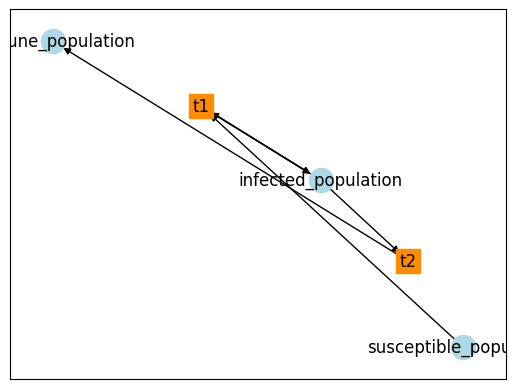

In [6]:
pyciemss.utils.draw_petri(petri_G)

{'state': ['beta', 'I'], 'transition': ['m']}


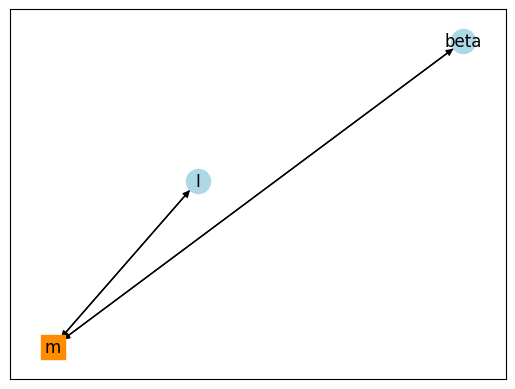

In [7]:
mandate_fragment = nx.MultiDiGraph()

mandate_fragment.add_node("m", type="transition", template_type="Logistic")
mandate_fragment.add_node("beta", type="state")
mandate_fragment.add_node("I", type="state")

mandate_fragment.add_edge("beta", "m")
mandate_fragment.add_edge("m", "beta")
mandate_fragment.add_edge("I", "m")
mandate_fragment.add_edge("m", "I")

pyciemss.utils.draw_petri(mandate_fragment)

In [8]:
mandate_fragment.nodes(data=True)

NodeDataView({'m': {'type': 'transition', 'template_type': 'Logistic'}, 'beta': {'type': 'state'}, 'I': {'type': 'state'}})

{'state': ['susceptible_population', 'infected_population', 'immune_population', 'beta', 'I'], 'transition': ['t1', 't2', 'm']}


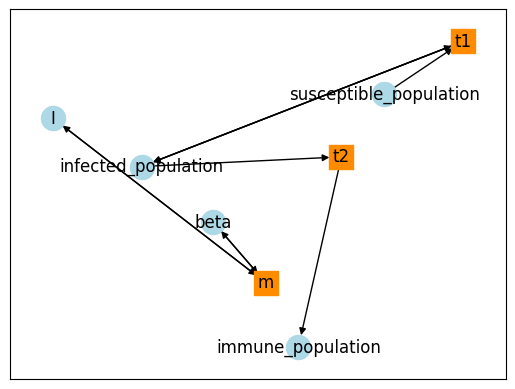

In [9]:
intervened_SIR_G = pyciemss.utils.intervene_petri_net(petri_G, m=mandate_fragment)
pyciemss.utils.draw_petri(intervened_SIR_G)